# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [2]:
df.email.nunique()

5148

In [3]:
count_article_per_user = df.groupby(by='email').article_id.count()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


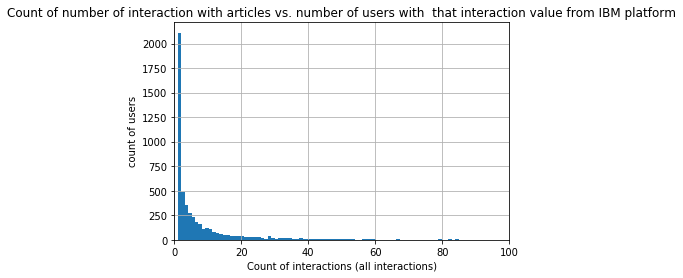

In [19]:
# article count is total, not just unique cases
print(count_article_per_user.describe())
plt.hist(count_article_per_user.values,bins=350);
plt.xlim([0, 100])
plt.grid()
plt.xlabel('Count of interactions (all interactions)')
plt.ylabel('count of users')
plt.title('Count of number of interaction with articles vs. number of users with  that interaction value from IBM platform');

Most of users interacted on average 3 time with articles. About 25% of population have viewed over 9 articles even up to 364 ineraction

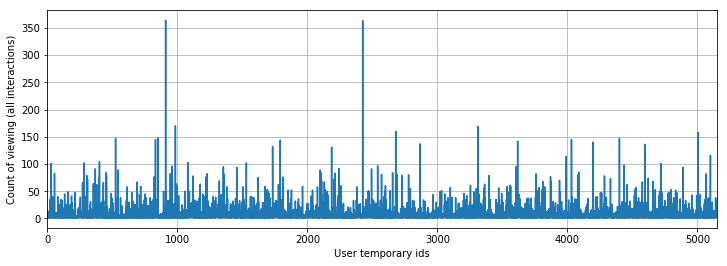

In [20]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0, df.email.nunique()), count_article_per_user.values)
plt.xlabel('User temporary ids')
plt.ylabel('Count of viewing (all interactions)')
plt.xlim([-1,5150]);
plt.grid()

In [21]:
count_article_per_user_article = df.groupby(by=['email','article_id']).article_id.count()

count    33669.000000
mean         1.365529
std          1.175020
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         42.000000
Name: article_id, dtype: float64


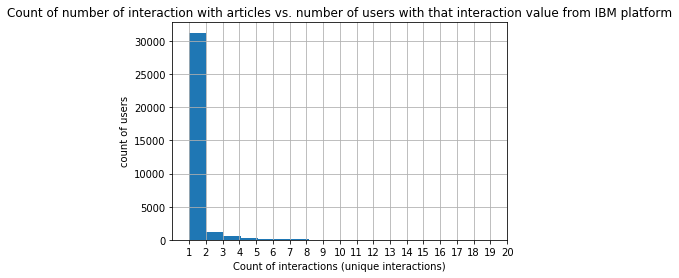

In [22]:
print(count_article_per_user_article.describe())
plt.hist(count_article_per_user_article.values, bins=40);
plt.xlim([0, 10])
plt.grid()
plt.xlabel('Count of interactions (unique interactions)')
plt.ylabel('count of users')
plt.xticks(np.arange(min(count_article_per_user_article.values), 20+1, 1.0));
plt.title('Count of number of interaction with articles vs. number of users with that interaction value from IBM platform');

In [27]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [28]:
# Find and explore duplicate articles
df_content.shape

(1056, 5)

In [29]:
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [31]:
list(df_content.columns)

['doc_body', 'doc_description', 'doc_full_name', 'doc_status', 'article_id']

In [32]:
df_content_clean = df_content.drop_duplicates(subset=['article_id','doc_full_name', 'doc_status'])

In [33]:
df_content.groupby(by=['article_id','doc_full_name', 'doc_status', 'doc_description', 'doc_description'])['article_id'].count().shape

(1051,)

In [34]:
df_content_clean.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [35]:
count_user_per_article = df.groupby(by='article_id').email.count()

In [36]:
df.article_id.nunique()

714

In [37]:
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [38]:
df.shape

(45993, 3)

In [40]:
df.dropna().email.nunique()

5148

In [42]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # (from content) The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users

# Question is not clear whether looking for number of unique interaction or not
user_article_interactions =  45993 # The number of user-article interactions (total: not unique, include NaN and duplicates)


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [43]:
df.groupby(by='article_id').count().sort_values(by=['email'], ascending=False).iloc[0:10,:]

,title,email
article_id,,
1429,937,937
1330,927,927
1431,671,671
1427,643,643
1364,627,627
1314,614,614
1293,572,572
1170,565,565
1162,512,512


In [44]:
most_viewed_article_id = '1429.0'  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [45]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
print('unique email, excluding nan',df.email.nunique())
del df['email']
df['user_id'] = email_encoded
print('unique userid, replaced nan',df.user_id.nunique())
df.article_id = df.article_id.astype('int64')
# show header
df.head()

unique email, excluding nan 5148
unique userid, replaced nan 5149


,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [46]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [52]:
print(df_content_clean.doc_full_name.loc[0])
print(df_content_clean.doc_description.loc[0])

Detect Malfunctioning IoT Sensors with Streaming Analytics
Detect bad readings in real time using Python and Streaming Analytics.


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [53]:
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [54]:
df_clean_id_title= df[['article_id','title']].drop_duplicates()
df_clean_id_title.head()

,article_id,title
0,1430,"using pixiedust for fast, flexible, and easier..."
1,1314,healthcare python streaming application demo
2,1429,use deep learning for image classification
3,1338,ml optimization using cognitive assistant
4,1276,deploy your python model as a restful api


In [55]:
# dictionary of item name and its id
dict_articleid_title = {}
dict_articleid_title = df_clean_id_title.set_index('article_id').T.to_dict('list')

In [56]:
dict_articleid_title[1276][0]

'deploy your python model as a restful api'

In [57]:

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_ids_list = get_top_article_ids(n, df)
    top_n_df = df.groupby(by=['article_id']).count().sort_values(by='title', ascending=False).reset_index().iloc[0:n]
    top_n_df = top_n_df.reset_index() 
    unique_id_title = df[['article_id','title']].drop_duplicates()
    unique_id_title = unique_id_title[unique_id_title.article_id.isin(top_ids_list)]
    top_articles = list(top_n_df.merge(unique_id_title, on='article_id', suffixes=('_', '')).title.values)

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    ids_list = list(df.groupby(by=['article_id']).count().sort_values(by='title', ascending=False)
                    .reset_index().iloc[0:n].article_id.values)
    top_articles = ids_list
    
    return top_articles # Return the top article ids

In [58]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [59]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [60]:
df_no_duplicate = df.drop_duplicates()

In [61]:
# create the user-article matrix with 1's and 0's
# Note the Description originally said matrix but test passes when output was dataframe, so added both cases

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item dataframe
    user_item_matrix - user item matrix
    Description:
    
    Return a matrix and a dataframe with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_no_duplicate = df.drop_duplicates()
    user_id_list = df_no_duplicate.user_id.unique()  #unique
    article_id_list = df_no_duplicate.article_id.unique() #unique
    
    user_item_matrix = np.zeros((len(user_id_list), len(article_id_list)))
    user_item = pd.DataFrame(user_item_matrix, columns=article_id_list, index=user_id_list)
    for user_id, article_id in df_no_duplicate[['user_id', 'article_id']].values:
        row = np.where(user_id_list == user_id)[0][0]
        col = np.where(article_id_list == article_id)[0][0]
        user_item_matrix[row, col] = 1
        user_item.loc[user_id, article_id] = 1
    
    return user_item, user_item_matrix # return the user_item matrix 

user_item, user_item_matrix = create_user_item_matrix(df)

In [62]:
user_item.head()

,1430,1314,1429,1338,1276,1432,593,1185,993,14,...,1135,881,183,655,1233,1156,555,708,575,972
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [74]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    most_similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    similarity_df - a dataframe containing each user and its neighbors order by similarity

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    user1 = user_id
    user_list = user_item.index
    user_similarity_array = []
    for user2 in user_list:  # removing owns or duplicates
        similarity = np.dot(user_item.loc[user1], user_item.loc[user2])
        user_similarity_array.append([user1, user2, similarity])
        
    similarity_df = pd.DataFrame(user_similarity_array, columns=['user1', 'user2', 'similarity'])  
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    similarity_df = similarity_df[similarity_df.user2 != user1] # remove user1==user2
    most_similar_users = similarity_df.user2.values
    
    return most_similar_users, similarity_df  # return a list of the users in order from most to least similar
        

In [76]:
most_similar_users, similarity_df=find_similar_users(1)
similarity_df[0:10]

,user1,user2,similarity
3932,1,3933,35.0
22,1,23,17.0
3781,1,3782,17.0
202,1,203,15.0
4458,1,4459,15.0
3869,1,3870,14.0
130,1,131,14.0
4200,1,4201,13.0
45,1,46,13.0
5040,1,5041,12.0


In [77]:
most_similar_users, similarity_df=find_similar_users(3933)
similarity_df[0:10]

,user1,user2,similarity
0,3933,1,35.0
22,3933,23,17.0
3781,3933,3782,17.0
202,3933,203,15.0
4458,3933,4459,15.0
130,3933,131,13.0
45,3933,46,13.0
3869,3933,3870,13.0
4200,3933,4201,13.0
48,3933,49,12.0


In [78]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[0][:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[0][:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[0][:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are: [   1   23 3782  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [79]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    df_clean_id_title= df[['article_id','title']].drop_duplicates()
    article_name_df = df_clean_id_title[df_clean_id_title.article_id.isin(article_ids)]
    
    for article_id in article_ids:
        article_names.append(article_name_df[article_name_df['article_id']==article_id].title.values[0])

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    df_user = user_item.loc[user_id]
    article_ids = list(df_user[df_user!=0.0].index)
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    all_articles = list(user_item.columns)
    user1 = user_id
    article_ids_user1_seen, _ = get_user_articles(user1, user_item=user_item)
    
    most_similar_users, similarity_df = find_similar_users(user1, user_item=user_item)
    x = similarity_df.sort_values(by='similarity', ascending=False)
    # get unique, then go through uniques if multiple and pick random from them
    unique_sim = x.similarity.unique()   
    
    # loop through all unique similarities
    for unique in unique_sim:
        y = similarity_df[similarity_df.similarity==unique]
        user2_list = y.user2.values
        unique_length= y.shape[0]
        # arbitary pick next user, with same similarities
        random_pick_similar = np.random.choice(user2_list, unique_length, replace=False)
        for user2 in random_pick_similar:
            article_ids_user2_seen, _ = get_user_articles(user2, user_item=user_item)
            article_ids_user1_notseen = np.setdiff1d(article_ids_user2_seen, article_ids_user1_seen)
            start_length = len(recs)
            # to avoid similar pointer,recs_tmp should not point same place as recs, so need only copy
            recs_tmp = recs.copy()   
            recs_tmp.extend(article_ids_user1_notseen)
            recs_tmp = list(set(recs_tmp))
            end_length = len(recs_tmp)

            # check before and after length, if more than m random pick
            if(end_length>=m):
                extra_count_needed = m - start_length
                list_get_rest = np.random.choice(article_ids_user1_notseen, extra_count_needed, replace=False)
                recs.extend(list_get_rest)
                recs = list(set(recs))
                return recs

            if(end_length<m):
                recs.extend(article_ids_user1_notseen)
                recs = list(set(recs))
                
    # user never meet required m rec
    return recs
   

In [80]:
get_article_names(user_user_recs(1, 10))

['learn tensorflow and deep learning together and now!',
 'aspiring data scientists! start to learn statistics with these 6 books!',
 'improving real-time object detection with yolo',
 'overlapping co-cluster recommendation algorithm (ocular)',
 'higher-order logistic regression for large datasets',
 'this week in data science (february 14, 2017)',
 'build a python app on the streaming analytics service',
 'working with db2 warehouse on cloud in data science experience',
 'web picks (week of 4 september 2017)',
 'experience iot with coursera']

In [82]:
# Test your functions here - No need to change this code - just run this cell
# article id put in integer format
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [84]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    user2 - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    unique_total - the number of unique articles viewed by the user 
                    overall_total - the number of overall articles viewed by the user 
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #unique interaction count
    x = df.drop_duplicates().groupby(by='user_id').count()  
    unique_total = x.reset_index()[['user_id','article_id']].rename(columns={"article_id": "unique_total"})
    #overall interaction count (even if user visited same unique article multiple time)
    x = df.groupby(by='user_id').count() 
    overall_total = x.reset_index()[['user_id','article_id']].rename(columns={"article_id": "overall_total"})
    merged_counts = unique_total.merge(overall_total, on='user_id')
    _, similarity_df = find_similar_users(user_id, user_item=user_item)
    z = similarity_df.merge(merged_counts, left_on='user2',right_on='user_id').drop(columns=['user_id'])
    # put priority by overall total (test staisfaction, otherwise think unique total count is more important)
    z = z.sort_values(by=['similarity','overall_total','unique_total'],ascending=False) 
    neighbors_df = z[z.user1==user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    all_articles = list(user_item.columns)
    user1 = user_id
    article_ids_user1_seen, _ = get_user_articles(user1, user_item=user_item)
    
    neighbors_df = get_top_sorted_users(user1, df=df, user_item=user_item)
    user2_list = neighbors_df.user2.values

    for user2 in user2_list:
        article_ids_user2_seen, _ = get_user_articles(user2, user_item=user_item)
        article_ids_user1_notseen = np.setdiff1d(article_ids_user2_seen, article_ids_user1_seen)
        start_length = len(recs)
        # to avoid similar pointer,recs_tmp should not point same place as recs, so need only copy
        recs_tmp = recs.copy()   
        recs_tmp.extend(article_ids_user1_notseen)
        recs_tmp = list(set(recs_tmp))
        end_length = len(recs_tmp)

        if(end_length>=m):
            extra_count_needed = m - start_length
            top_100_articles = get_top_article_ids(100, df=df)
            list1_df = pd.DataFrame(np.array(top_100_articles))
            list2_df = pd.DataFrame(np.array(article_ids_user1_notseen))
            # intersection of the two lists but with top_100_priority and get extra_count_needed from top
            list_get_rest = list1_df.merge(list2_df)[0].values[0:extra_count_needed]            
            recs.extend(list_get_rest)
            recs = list(set(recs))
            rec_names = get_article_names(recs)
            return recs, rec_names

        if(end_length<m):
            recs.extend(article_ids_user1_notseen)
            recs = list(set(recs))

    #if user never meet m recommendation
    rec_names = get_article_names(recs)
    return recs, rec_names


In [85]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1368, 1351, 1160, 1162, 1354, 1330, 1427, 1364, 1170, 1304]

The top 10 recommendations for user 20 are the following article names:
['putting a human face on machine learning', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'analyze energy consumption in buildings', 'movie recommender system with spark machine learning', 'insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'gosales transactions for logistic regression model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [87]:
get_top_sorted_users(1, df=df, user_item=user_item).user2[0]

3933

In [88]:
get_top_sorted_users(131, df=df, user_item=user_item).user2.values[9] # 10th item

242

In [89]:
get_top_sorted_users(131, df=df, user_item=user_item).head(11)

,user1,user2,similarity,unique_total,overall_total
0,131,3870,74.0,75,144
1,131,3782,39.0,135,363
2,131,23,38.0,135,364
4,131,203,33.0,96,160
3,131,4459,33.0,96,158
6,131,98,29.0,97,170
5,131,3764,29.0,97,169
8,131,49,29.0,101,147
7,131,3697,29.0,100,145
10,131,242,25.0,59,148


In [90]:
### Tests with a dictionary of results

user1_most_sim = 3933  # Find the user that is most similar to user 1 
user131_10th_sim = 242  # Find the 10th most similar user to user 131

In [91]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

*___________________________*
For the new user (__cold start problem__), the user-user base method alone is not appropriate and in general any method that rely on user previous viewing history in the system (e.g. SVD type recommendation, article content-base, item-item base) isn't able to find a neighborhood for him/her. There are few other options available though:**

- Using knowledge-base method, and maybe even expand it to rank-base method based on using most popular items for recommendation. For new users we can ask them initially few questions to know what their interests are to get better filtering for rank-base recommendation.
- Another approach which is not discussed here is to ask new users to fill more detailed questionnaire when they sign up to the website and to dive deeper into user characteristics/behavior/demography such as habits, age, genre, zip code to build more elaborate user content-base approach (to classify user characteristics, not articles).
- As soon as user start building viewing history, then we can add methods such as article content-base, SVD, item-item base approach (Amazon uses), or user-user base methods.
- Generally it is shown for a well-established website which has more users than items, item-item base method (which is not dicussed in Udacity course work) is better than user-user base method. The item-item is used in Amazon, Netflix,.. and relies on pair of item-item similarity based on user views/rating.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [92]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) 
print(new_user_recs)
#The output from my recommendation is integer, need to convert to string
new_user_recs = [str(np.round(float(i),1)) for i in new_user_recs]
print(new_user_recs)


[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [93]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [94]:
# Load the matrix here
user_item_matrix_udacity = pd.read_pickle('user_item_matrix.p')

In [95]:
# quick look at the matrix
user_item_matrix_udacity.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [96]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix_udacity) 
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [97]:
user_item_matrix_udacity.shape

(5149, 714)

- In the lesson the user-matrix was filled with rating of the movies, and in case user had not seen the movie the rating was set to NaN. The NaN led to normal SVD method crash, since matrix was not well defined so we had to use FunkSVD to get predicted rating for unseen movies. Here there is no article rating available, and only viewing/not-viewing is important. The not-seen articles by the users set to zero so still a finite number, and matrix become well defined. Therefore, SVD calculation is possible.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [98]:
# Using my own user_item_matrix is more readable
user_item.head()

,1430,1314,1429,1338,1276,1432,593,1185,993,14,...,1135,881,183,655,1233,1156,555,708,575,972
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This calculation that is from Udacity notebook and using df.shape[0] to divide the error seems to be very arbitary
By dividing by df.shape[0] only "1" entries in user_matrix considered, even when error from all "0"/"1" cases
it is better to divide by max_error that also consideres "0" cases


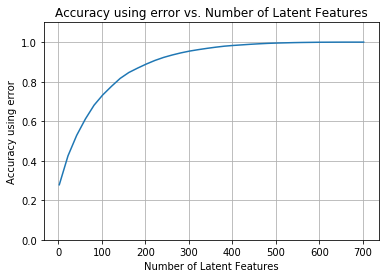

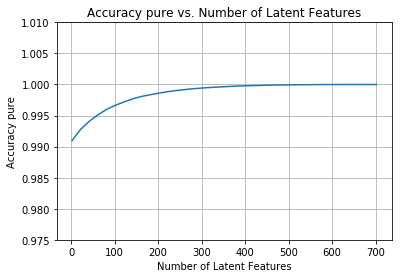

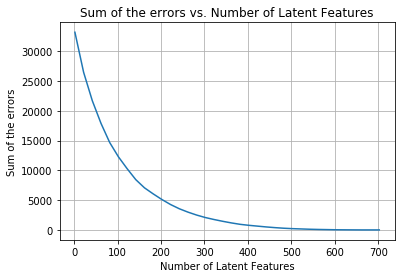

In [99]:
u, s, vt = np.linalg.svd(user_item) 
num_latent_feats = np.arange(2,700+10,20)
sum_errs = []
tolerance = 1e-10
acc = []

for k in num_latent_feats:
    # restructure with k latent features
    s_latent, u_latent, vt_latent = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_latent, s_latent), vt_latent))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    acc.append((user_item == user_item_est).mean().mean())
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

# total user/matrix combintation need to be predicted   
max_error = user_item.shape[0]*user_item.shape[1]
# correct is max_error instead of df.shape[0], if look for accuracy of whole prediction, not just the ones that are 1.0
print('This calculation that is from Udacity notebook and using df.shape[0] to divide the error seems to be very arbitary')
print('By dividing by df.shape[0] only "1" entries in user_matrix considered, even when error from all "0"/"1" cases')
print('it is better to divide by max_error that also consideres "0" cases')
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]) 
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy using error');
plt.title('Accuracy using error vs. Number of Latent Features');
plt.grid()
plt.ylim([0.0,1.1]);
plt.show()

plt.plot(num_latent_feats, acc); 
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy pure');
plt.title('Accuracy pure vs. Number of Latent Features');
plt.grid()
plt.ylim([0.975,1.01]);
plt.show()

plt.plot(num_latent_feats, np.array(sum_errs)); 
plt.xlabel('Number of Latent Features');
plt.ylabel('Sum of the errors');
plt.title('Sum of the errors vs. Number of Latent Features');
plt.grid()
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [101]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    train_idx - all of the train user ids
    train_arts - all of the train article ids                    
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train, _ = create_user_item_matrix(df_train)
    user_item_test, _ = create_user_item_matrix(df_test)
    train_idx = user_item_train.index.values
    train_arts = user_item_train.columns.values
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, train_idx, train_arts, test_idx, test_arts

user_item_train, user_item_test, train_idx, train_arts, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [102]:
print('number of unique users in train', len(user_item_train.index.values))
print('number of unique users in test', len(user_item_test.index.values))
print('number of unique overlap users in train/test', len(np.intersect1d(user_item_train.index.values, user_item_test.index.values)))
print('number of unique users in test but not in train', len(np.setdiff1d(user_item_test.index.values, user_item_train.index.values)))

number of unique users in train 4487
number of unique users in test 682
number of unique overlap users in train/test 20
number of unique users in test but not in train 662


In [103]:
print('number of unique articles in train', len(user_item_train.columns.values))
print('number of unique articles in test', len(user_item_test.columns.values))
print('number of unique overlap articles in train/test', len(np.intersect1d(user_item_train.columns.values, user_item_test.columns.values)))
print('number of unique in articles in test but not in train', len(np.setdiff1d(user_item_test.columns.values, user_item_train.columns.values)))

number of unique articles in train 714
number of unique articles in test 574
number of unique overlap articles in train/test 574
number of unique in articles in test but not in train 0


In [104]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

Accuracy using error, this approach is not ideal either, due to very unbalance data. Better is using F1_score.


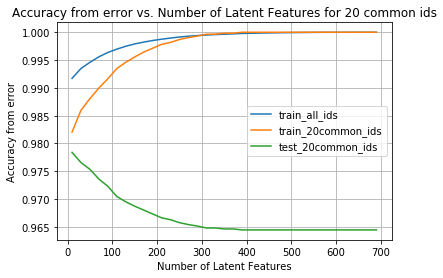

Accuracy by matched counts/consistent with error
 however, again this approach is not ideal either, due to very unbalance data. Better is using F1_score.


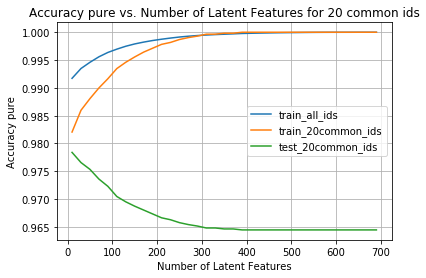

Using f1_score shows the unbalance impact,
 The F1_score shows poor performance on the test set. Need cross-validation to check consistency


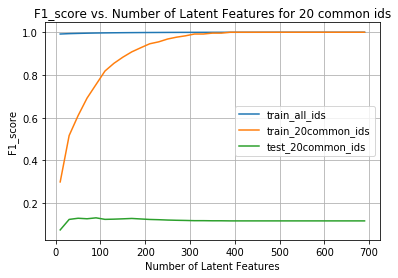

In [107]:
# SVD on train set
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 
num_latent_feats = np.arange(10,700+10,20)

sum_errs_train_all = []
sum_errs_train = []
sum_errs_test = []
acc_train_all = []
acc_train = []
acc_test = []
tolerance = 1e-10

f1_score_train_all = []
f1_score_train = []
f1_score_test = []

for k in num_latent_feats:
    # train/test common 20 overlap userids
    overlap_idx = np.intersect1d(train_idx, test_idx)
    # train/test common 574 overlap articles
    overlap_arts = np.intersect1d(train_arts, test_arts)
    # restructure with k latent features
    s_latent, u_latent, vt_latent = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product train
    user_item_est = np.around(np.dot(np.dot(u_latent, s_latent), vt_latent))
    # make df from reconstrcut
    user_item_est_df = pd.DataFrame(user_item_est, index=train_idx, columns=train_arts)
    # get 20 common user from original train
    train_20_actual = user_item_train.loc[overlap_idx, overlap_arts]
    # get 20 common user from reconstruct
    train_20_est = user_item_est_df.loc[overlap_idx, overlap_arts]
    # test set
    test_20_actual = user_item_test.loc[overlap_idx, overlap_arts]
    # get 20 common user from reconstruct
    test_20_est = user_item_est_df.loc[overlap_idx, overlap_arts]    
    
    # compute error for each prediction to actual value
    # all train
    diffs_train_all = np.subtract(user_item_train, user_item_est_df)
    # train for 20 common user
    diffs_train = np.subtract(train_20_actual, train_20_est)
    # test for 20 common user
    diffs_test = np.subtract(test_20_actual, test_20_est)

    # total errors and keep track of them
    # all train
    err_train_all = np.sum(np.sum(np.abs(diffs_train_all)))
    # train for 20 common user
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    # test for 20 common user    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    # all train    
    sum_errs_train_all.append(err_train_all)
    # train for 20 common user   
    sum_errs_train.append(err_train)
    # test for 20 common user       
    sum_errs_test.append(err_test)

    # Accuracy
    # all train
    acc_train_all.append((user_item_train == user_item_est_df).mean().mean())
    # train 20 common
    acc_train.append((train_20_actual == train_20_est).mean().mean())
    # test 20 common
    acc_test.append((test_20_actual == test_20_est).mean().mean())
    
    y_actual_train_all = np.abs(user_item_train.astype('int64')).as_matrix()
    y_pred_train_all = np.abs(user_item_est_df.astype('int64')).as_matrix()
    y_actual_train = np.abs(train_20_actual.astype('int64')).as_matrix()
    y_pred_train = np.abs(train_20_est.astype('int64')).as_matrix()
    y_actual_test = np.abs(test_20_actual.astype('int64')).as_matrix()
    y_pred_test = np.abs(test_20_est.astype('int64')).as_matrix()  
    
    # f1 score for all train/ 20 common train/20 common test
    f1_score_train_all.append(f1_score(y_actual_train_all.flatten(), y_pred_train_all.flatten(), average='micro'))
    f1_score_train.append(f1_score(y_actual_train.flatten(), y_pred_train.flatten()))
    f1_score_test.append(f1_score(y_actual_test.flatten(), y_pred_test.flatten()))
    

print('Accuracy using error, this approach is not ideal either, due to very unbalance data. Better is using F1_score.')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train_all)/(user_item_train.shape[0]*user_item_train.shape[1]))
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(train_20_actual.shape[0]*train_20_actual.shape[1])) #  replaced 1 - np.array(sum_errs)/df.shape[0]
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(test_20_actual.shape[0]*test_20_actual.shape[1]))
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy from error');
plt.title('Accuracy from error vs. Number of Latent Features for 20 common ids');
plt.legend(['train_all_ids', 'train_20common_ids', 'test_20common_ids'])
plt.grid()
plt.show()
print('Accuracy by matched counts/consistent with error\n',
'however, again this approach is not ideal either, due to very unbalance data. Better is using F1_score.')
plt.plot(num_latent_feats, acc_train_all)
plt.plot(num_latent_feats, acc_train)
plt.plot(num_latent_feats, acc_test)
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy pure');
plt.title('Accuracy pure vs. Number of Latent Features for 20 common ids');
plt.legend(['train_all_ids', 'train_20common_ids', 'test_20common_ids'])
plt.grid()
plt.show()

print('Using f1_score shows the unbalance impact,\n',
'The F1_score shows poor performance on the test set. Need cross-validation to check consistency')
plt.plot(num_latent_feats, f1_score_train_all)
plt.plot(num_latent_feats, f1_score_train)
plt.plot(num_latent_feats, f1_score_test)
plt.xlabel('Number of Latent Features');
plt.ylabel('F1_score');
plt.title('F1_score vs. Number of Latent Features for 20 common ids');
plt.legend(['train_all_ids', 'train_20common_ids', 'test_20common_ids'])
plt.grid()
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

- First the overlap samples between the train and test set is very very small (20 users) to get a concrete conclusion on the performance of test data. Accuracy values checked with sum of the error as well number of matched predictions, they are consistent. Based on the results on the test data, accuracy of the train set shows an overfitting, the test set accuracy continues to deline and saturate at around 300 latent features, one might decide to not add more latent features over 300. Beyond that there is no further changes neither to train or test accuracy. The accuracy values specially for the test data should be taken with a grain of salt. The user_item matrix is highly unbalanced and the very high accuracy >90% are dominated by predicting the "0" cases correctly, when user has not viewed the article. In an ideal case, one would hope that model predict the "1"s more, which are cases that article is viewed. To get an estimate on this F1_Score is also tracked and unfortunately shows poor perfromance ~12% on the test set, the F1_score never improves beyond 100 latent feature. Again all these conclusion is dervied from one train/test split. The percentage of test population is about 13% of overall population.


- Ways to gain better understanding about the results is: to increase the test sample to about 20-30% of whole population to hopefully get more common users for more reliable predictability. Additionally use cross-validation and check accuracy and more importantly the f1_score/f_beta score with k-folds. To do the k-fold, we divide the data into k-1 training fold, and 1 test fold. In k-1 training fold, build one training user_article matrix and SVD. Then test the accuracy/f1_score/f_beta results on one remaining fold. We can observe the variability between k-folds score. We can also add randomization, and build each k-fold set with a specific random state. Observing all the variations in score with various random state and k-folds gives us capability of our prediction with SVD. The final score is average of k scores, and also random state results for a fully random case that covers all corners for reporting test cases.


- One of the issue with this dataset is the absence of timestamp information. It is not clear what is the sequence and order of article being visited by a user in time. User may tend to read certain article and that article persuade him/her to dig even deeper or move on to new topic. Element of time can be additional factor in correlation. Knowing the sequence of article viewing for a neighbor can suggest similar sequence for user, a concept resenbeling time series cases. Also by considering time when dataset is actually divided into train and test case it is better the prediction for the test be in future time (later interactions). In current state this dataset is missing these information.

- If there is no recommendation available, users perhaps need to do manually search for particular key work, or randomly pick through list of articles, or pick an article based on suggestion of friend or another user, again not automatic. Randomly picking an article, considering 714 unique article, give very low probability, not feasible


- Few extra thoughts: 1) This can be a twist on k-fold is when dividing the data into k-fold, with the k-1 fold do k-1 separate cases of SVD calculation (k-1 cases of training data, each contain 1/k th of data, instead of (k-1)/k). Then common users/matrix combinations between k-1 sets get a majority vote among k-1 cases. The majority voted results then fed into remaining 1 fold test case for common user/matrix. 2) instead of filling the user_matrix with "0", we use NaN and follow Simon Funk SVD method but definitely add regularization to total error and include gradients of regularization so to avoid overfitting to the problem.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])